In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
csv_path = "../ml/data/processed/china_mill_data_2025_03_04_09_30_30.csv"
features = ["energy"]

input_window = 3360  # Past input sequence
output_window = 480  # Future prediction sequence
batch_size = 32
epochs = 50
hidden_size = 64
learning_rate = 0.001

In [38]:
def preprocess(csv_path, features, input_window, output_window):
    df = pd.read_csv(csv_path, parse_dates=["time"])
    df = df.sort_values("time").set_index("time")[features]

    # Store original energy for comparison
    original_energy = df['energy'].copy()

    # Handle zero values
    energy = df["energy"].copy()
    mask = energy == 0
    first_nonzero_idx = energy.ne(0).idxmax()
    mask.loc[:first_nonzero_idx] = False
    energy.loc[mask] = np.nan
    energy = energy.ffill()
    df["energy"] = energy
    df = df.ffill()

    print("Plotting original vs filtered energy")
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, original_energy, label='Original Energy', alpha=0.5, linestyle='--')
    plt.plot(df.index, df['energy'], label='Filtered Energy', alpha=0.5)
    plt.title('Original vs Filtered Energy Values')
    plt.xlabel('Time')
    plt.ylabel('Energy Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(scaled) - input_window - output_window):
        # Input: 3360 steps
        X.append(scaled[i:i+input_window])
        # Output: 480 steps **AFTER** input
        y.append(scaled[i+input_window:i+input_window+output_window])

    X = np.array(X)
    y = np.array(y)
    
    print(f"✅ Input shape: {X.shape}, Output shape: {y.shape}")
    return X, y, scaler

Plotting original vs filtered energy


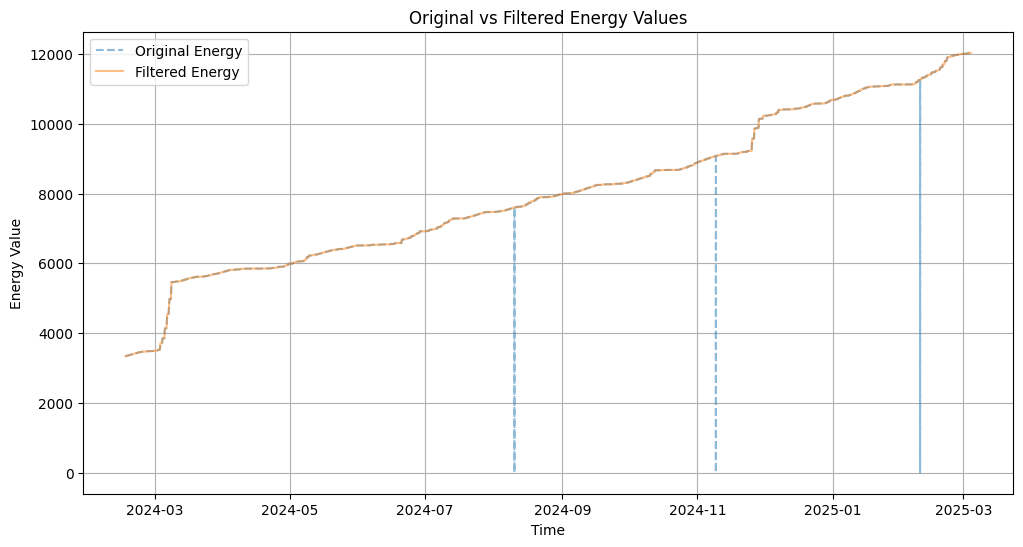

✅ Input shape: (126160, 3360, 1), Output shape: (126160, 480, 1)


In [39]:
X, y, scaler = preprocess(csv_path, features, input_window, output_window)

In [40]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [20]:
def build_seq2seq(input_shape, output_steps, hidden_size, learning_rate):
    model = Sequential()
    model.add(LSTM(hidden_size, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(hidden_size, return_sequences=True))
    model.add(Lambda(lambda x: x[:, -output_window:, :]))
    model.add(TimeDistributed(Dense(1)))  # Predict 1 feature per step

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="mse", metrics=["mae", "mse"])
    return model

In [21]:
model = build_seq2seq(input_shape=(input_window, 1), output_steps=output_window,
                      hidden_size=hidden_size, learning_rate=learning_rate)

2025-04-23 13:01:48.689158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 13:01:48.689912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 13:01:48.690526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3360, 64)          16896     
                                                                 
 lstm_3 (LSTM)               (None, 3360, 64)          33024     
                                                                 
 lambda (Lambda)             (None, 480, 64)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 480, 1)           65        
 tributed)                                                       
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [26]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop]
)

Epoch 1/50


2025-04-23 13:02:07.419147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 13:02:07.419679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 13:02:07.420482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3154/3154 [==============================] - ETA: 0s - loss: 4.0495e-04 - mae: 0.0059 - mse: 4.0495e-04

2025-04-23 13:18:05.473789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 13:18:05.474422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 13:18:05.475191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3154/3154 [==============================] - 1033s 327ms/step - loss: 4.0495e-04 - mae: 0.0059 - mse: 4.0495e-04 - val_loss: 2.9838e-05 - val_mae: 0.0037 - val_mse: 2.9838e-05
Epoch 2/50
3154/3154 [==============================] - 1003s 318ms/step - loss: 8.7289e-05 - mae: 0.0052 - mse: 8.7289e-05 - val_loss: 3.4708e-05 - val_mae: 0.0053 - val_mse: 3.4708e-05
Epoch 3/50
3154/3154 [==============================] - 1023s 324ms/step - loss: 8.5754e-05 - mae: 0.0051 - mse: 8.5754e-05 - val_loss: 2.3964e-05 - val_mae: 0.0040 - val_mse: 2.3964e-05
Epoch 4/50
3154/3154 [==============================] - 988s 313ms/step - loss: 8.0883e-05 - mae: 0.0048 - mse: 8.0883e-05 - val_loss: 4.1454e-05 - val_mae: 0.0049 - val_mse: 4.1454e-05
Epoch 5/50
3154/3154 [==============================] - 972s 308ms/step - loss: 5.5731e-05 - mae: 0.0046 - mse: 5.5731e-05 - val_loss: 8.6282e-05 - val_mae: 0.0072 - val_mse: 8.6282e-05
Epoch 6/50
3154/3154 [==============================] - 1259s 399ms/step - los

In [27]:
model.save("china_mill_seq2seq_480.h5")

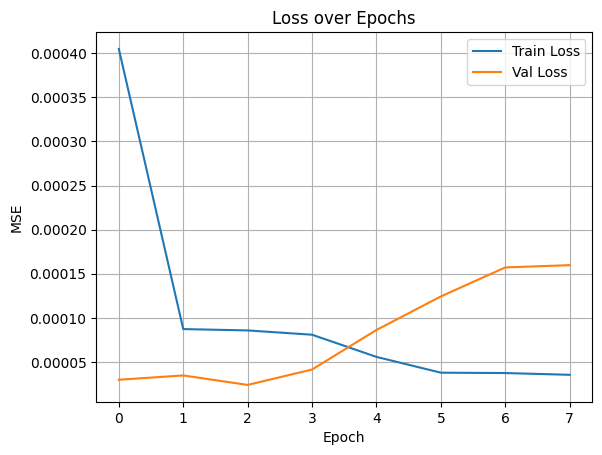

In [36]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()


In [41]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

789/789 [==============================] - 79s 100ms/step


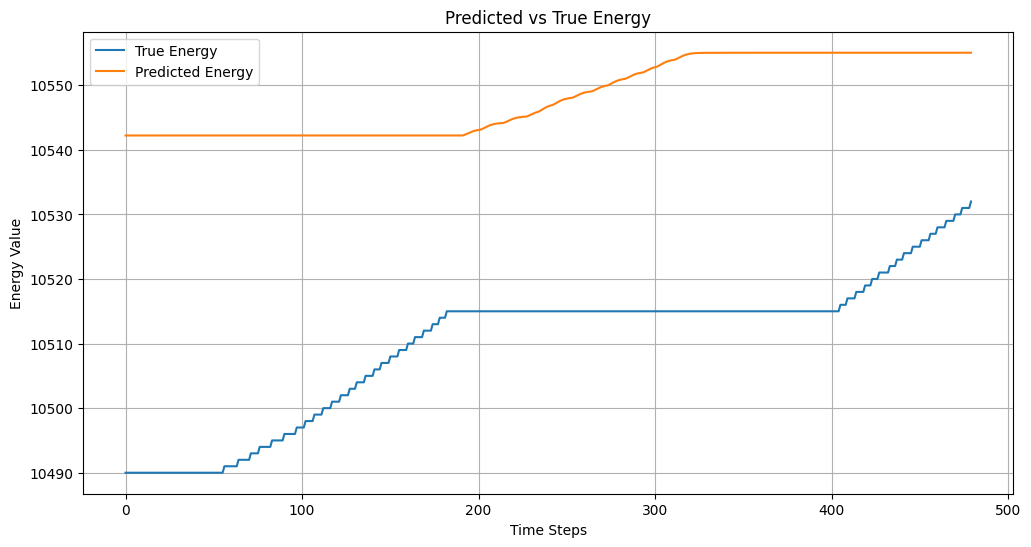

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[0], label="True Energy")
plt.plot(predictions[0], label="Predicted Energy")
plt.title("Predicted vs True Energy")
plt.xlabel("Time Steps")
plt.ylabel("Energy Value")
plt.legend()
plt.grid(True)
plt.show()